# Single Slew M1M3 Inertia Compensation System Analysis

This notebook is part of [SITCOMTN-092].  
Use it to analyze a single slew.  

The bulk analysis has been moved to [lsst-sitcom/summit_utils].  
You will need to have it cloned and use the `tickets/DM-51023` branch until it is done.    
Once the ticket is complete and the PR is merged, use `sitcom-performance-analysis` or `develop`.  
Refer to the [README.md] file for details on how to set up this repository in your environment.

  
[lsst-sitcom/summit_utils]: https://github.com/lsst-sitcom/summit_utils
[README.md]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/README.md
[SITCOM-989]: https://jira.lsstcorp.org/browse/SITCOM-989
[SITCOMTN-092]: https://sitcomtn-092.lsst.io/

## Notebook Preparation

In [24]:
day_obs = 20250527
slew_id = 37
tma_event_version = 0

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time
from pathlib import Path

# This notebooks requires `summit_utils` with the `tickets/DM-51023` branch.
#  Once this branch is merged, use `develop` or `sitcom-performance-analysis` instead.
from lsst.summit.utils.m1m3 import inertia_compensation_system as ics
from lsst.summit.utils.m1m3.plots import plot_ics
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import (
    getCommandsDuringEvent,
    TMAEvent,
    TMAEventMaker,
    TMAState,
)
from lsst.summit.utils.utils import setupLogging

setupLogging()

## Create Event Maker

We want to create a single instance of the `TMAEventMaker` object.  
Each instance might be quite heavy. 

In [27]:
plot_path = Path("./plots")
plot_path.mkdir(exist_ok=True, parents=True)

tma_event_maker = TMAEventMaker()
efd_client = makeEfdClient()

## Helper functions

In [35]:
def analyze_m1m3_ics_slew_event(begin, end, event_maker, log, path=None):
    """
    Plot the ICS performance analysis in a single slew.
    Three axes are created. The top representes the hard point forces.
    The second shows the velocity in azimuth and elevation.
    The thierd shows the torques in azimuth and elevation.

    Parameters
    ----------
    begin : str
        Approximate time of when the slew began in UTC using iso format.
    end : str
        Approximate time of when the slew ended in UTC using iso format.
    event_maker :
        TMA event maker
    log :
        Logger
    path : Path, optional
        Path to store plots
    """
    time_begin = Time(begin, format="isot", scale="utc")
    time_end = Time(end, format="isot", scale="utc")
    time_half = time_begin + (time_end - time_begin) * 0.5

    event = event_maker.findEvent(time_half)
    print(
        f"Slew happened from {begin=} to {end=} "
        f"and has sequence number {event.seqNum} "
        f"and observation day {event.dayObs}"
    )

    data = ics.M1M3ICSAnalysis(event, event_maker.client)
    name = f"ics_performance_ics_hp{data.stats.ics_enabled}_{data.stats.day_obs}_sn{data.stats.seq_num}_v{data.stats.version}"

    commands = getCommandsDuringEvent(
        event_maker.client, event, hardpoint_commands_to_plot
    )

    print(commands)
    
    fig = plt.figure(num=name, figsize=(10, 5), dpi=120)
    fig = plot_ics.plot_hp_measured_data(
        data, log=data.log, fig=fig, commands=commands
    )

    if path:
        fig.savefig(str(path / f"{name}"))

    # plt.show()

    return data

## Analysis

### Get all slews in a day

This analysis assume that you already have done the following steps and that you already know what is the slew ID you want to plot. In RubinTV, this slew ID is called as Sequence Number. It is the first column on the left in the [TMA RubinTV Page].

[TMA RubinTV Page]: https://summit-lsp.lsst.codes/rubintv/summit/tma

In [29]:
tma_events = tma_event_maker.getEvents(day_obs)
track_events = [e for e in tma_events if e.type == TMAState.TRACKING]
slew_events = [e for e in tma_events if e.type == TMAState.SLEWING]

print(
    f"Found {len(tma_events)} TMA Events on day_obs={day_obs}\n"
    f"  Number of tracking events: {len(track_events)}\n"
    f"  Number of slewing events: {len(slew_events)}\n"
)

Found 40 TMA Events on day_obs=20250527
  Number of tracking events: 14
  Number of slewing events: 26



We know from the plots in RubinTV for `20250527` that the plots associates with Slew 37 show that the forces applied on the hard points are higher than the operational limit, but are still lower than the fatigue or safety limimt. So let's use it for further analysis.

## Analyze M1M3 ICS per Slew Event



In [38]:
event = tma_events[slew_id]

Slew happened from 1748401619.386454 to 1748401643.2087362
  and has sequence number 37
  and observation day 20250527



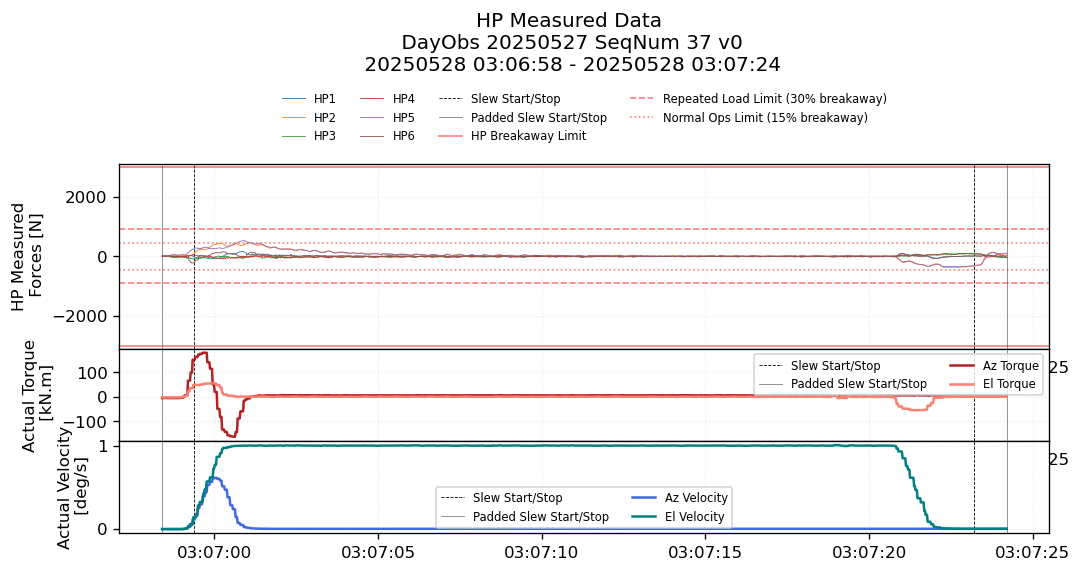

In [42]:
print(
    f"Slew happened from {event.begin} to {event.end}\n"
    f"  and has sequence number {event.seqNum}\n"
    f"  and observation day {event.dayObs}\n"
)

data = ics.M1M3ICSAnalysis(event, tma_event_maker.client)
name = f"ics_performance_ics_hp{data.stats.ics_enabled}_{data.stats.day_obs}_sn{data.stats.seq_num}_v{data.stats.version}"

commands = getCommandsDuringEvent(
    tma_event_maker.client, event, hardpoint_commands_to_plot
)

fig = plt.figure(num=name, figsize=(10, 5), dpi=120)
fig = plot_ics.plot_hp_measured_data(
    data, log=data.log, fig=fig, commands=commands
)

if plot_path:
    fig.savefig(str(plot_path / f"{name}"))

plt.show()

## Backward compatible slew analysis

The following data is quite old and we collected them during the M1M3+M2 Surrogates test campaings.  
We are keeping them here to ensure that the analysis code is backward compatible.

In [30]:
slew_data = {
    # First data obtained at 30% motion settings and ICS disabled
    "20230727_ics_False_30": dict(
        begin="2023-07-28T02:17:15", end="2023-07-28T02:17:55"
    ),
    # Second data obtained at 30% motion settings and ICS enabled
    "20230802_ics_True_30": dict(
        begin="2023-08-02T22:02:30", end="2023-08-02T22:04:00"
    ),
    # Third data obtained at 50% motion settings and ICS enabled
    "20230802_ics_True_50": dict(
        begin="2023-08-03T03:20:30", end="2023-08-03T03:21:20"
    ),
    # More recent data obtained at Full Performance and ICS enabled
    "20231129_ics_True_100": dict(
        begin="2023-11-30T08:46:44", end="2023-11-30T08:47:45"
    ),
}

hardpoint_commands_to_plot = [
    "lsst.sal.MTM1M3.command_setSlewFlag",
    "lsst.sal.MTM1M3.command_enableHardpointCorrections",
    "lsst.sal.MTM1M3.command_clearSlewFlag",
]

### Case 1 - ICS Disabled and 30% TMA Performance

Slew happened from begin='2023-07-28T02:17:15' to end='2023-07-28T02:17:55' and has sequence number 53 and observation day 20230727


day_obs                        20230727
seq_num                              53
slew_type                             2
end_reason                            0
time_duration                 38.226104
time_begin            1690510635.459096
time_end             1690510673.6852002
version                               0
az_start                       2.886197
az_end                        16.563506
az_extreme_vel                -3.006999
az_extreme_torque           -532.383342
el_start                      -2.054348
el_end                        -1.757695
el_extreme_vel                -0.011262
el_extreme_torque             -2.820801
ics_enabled                       False
az_diff                       13.677309
el_diff                        0.296653
measuredForceMin0           -700.257507
measuredForceMin1          -1143.344482
measuredForceMin2           -673.972046
measuredForceMin3           -507.105652
measuredForceMin4           -565.595642
measuredForceMin5           -613.490845


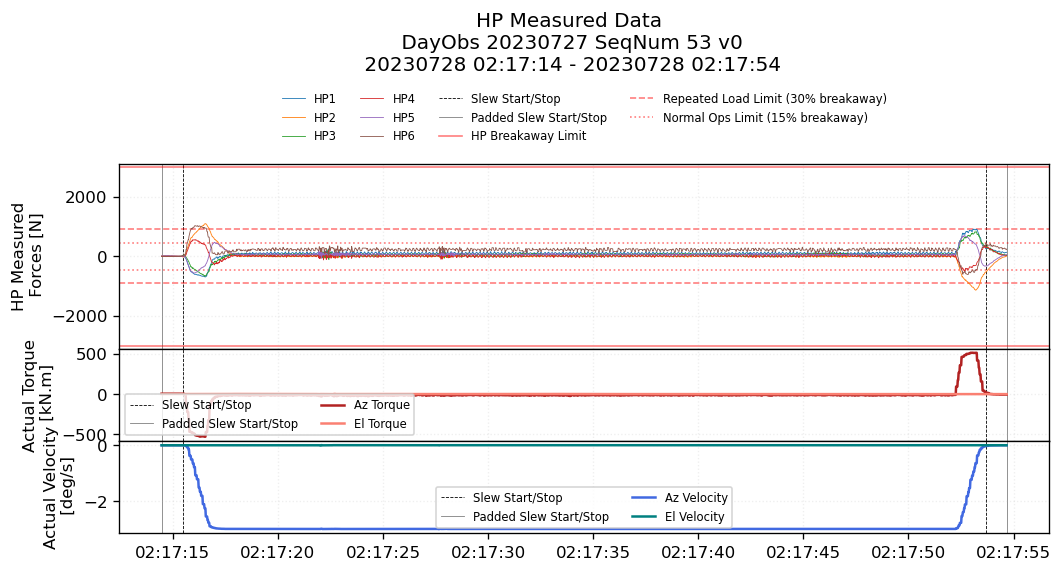

In [31]:
%matplotlib inline
data = analyze_m1m3_ics_slew_event(
    slew_data["20230727_ics_False_30"]["begin"],
    slew_data["20230727_ics_False_30"]["end"],
    tma_event_maker,
    plot_path,
)

data.stats

### Case 2 - ICS Enabled and 30% TMA Performance

Slew happened from begin='2023-08-02T22:02:30' to end='2023-08-02T22:04:00' and has sequence number 38 and observation day 20230802


day_obs                        20230802
seq_num                              38
slew_type                             2
end_reason                            0
time_duration                 68.137561
time_begin           1691013758.7702384
time_end             1691013826.9077997
version                               0
az_start                      -6.776973
az_end                       -41.079246
az_extreme_vel                 3.009254
az_extreme_torque            537.746971
el_start                      -0.523568
el_end                        -0.551243
el_extreme_vel                -0.005064
el_extreme_torque             -1.434677
ics_enabled                       False
az_diff                      -34.302273
el_diff                       -0.027674
measuredForceMin0           -727.673706
measuredForceMin1           -652.610535
measuredForceMin2           -435.129242
measuredForceMin3           -572.149597
measuredForceMin4           -739.137207
measuredForceMin5           -630.735229


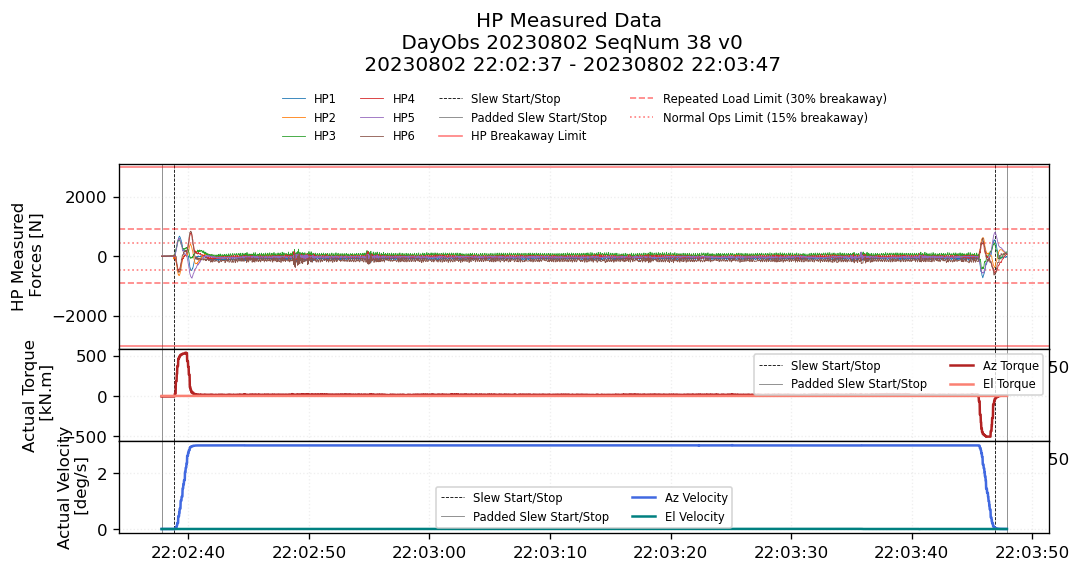

In [32]:
%matplotlib inline
data = analyze_m1m3_ics_slew_event(
    slew_data["20230802_ics_True_30"]["begin"],
    slew_data["20230802_ics_True_30"]["end"],
    tma_event_maker,
    plot_path,
)

print(data.stats)

### Case 3 - ICS Enabled and 50% TMA Performance

Slew happened from begin='2023-08-03T03:20:30' to end='2023-08-03T03:21:20' and has sequence number 324 and observation day 20230802


day_obs                        20230802
seq_num                             324
slew_type                             2
end_reason                            0
time_duration                 39.586277
time_begin           1691032834.5629182
time_end             1691032874.1491947
version                               0
az_start                      -6.813627
az_end                        -76.79373
az_extreme_vel                 5.256971
az_extreme_torque            926.089338
el_start                      -0.397409
el_end                        -0.781522
el_extreme_vel                 0.019048
el_extreme_torque              2.296661
ics_enabled                       False
az_diff                      -69.980104
el_diff                       -0.384112
measuredForceMin0          -1231.740601
measuredForceMin1          -1141.045898
measuredForceMin2           -919.541382
measuredForceMin3           -974.981689
measuredForceMin4          -1483.158203
measuredForceMin5           -1288.00293


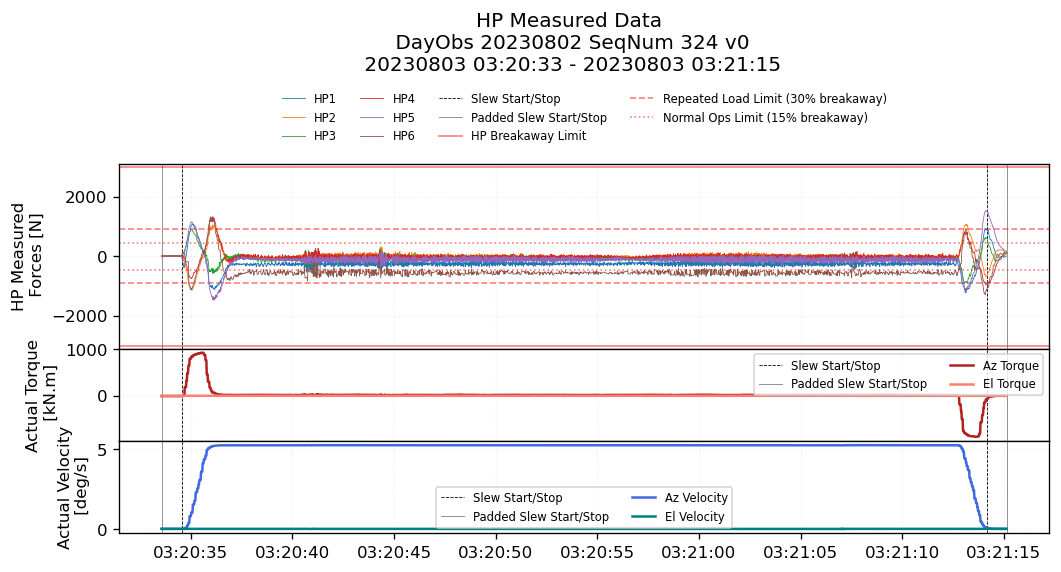

In [33]:
%matplotlib inline
data = analyze_m1m3_ics_slew_event(
    slew_data["20230802_ics_True_50"]["begin"],
    slew_data["20230802_ics_True_50"]["end"],
    tma_event_maker,
    plot_path,
)

print(data.stats)

### Case 4 - ICS Enabled and 100% TMA Performance

Slew happened from begin='2023-11-30T08:46:44' to end='2023-11-30T08:47:45' and has sequence number 863 and observation day 20231129
{datetime.datetime(2023, 11, 30, 8, 47, 43, 66201, tzinfo=datetime.timezone.utc): 'lsst.sal.MTM1M3.command_setSlewFlag', datetime.datetime(2023, 11, 30, 8, 46, 59, 996730, tzinfo=datetime.timezone.utc): 'lsst.sal.MTM1M3.command_enableHardpointCorrections', datetime.datetime(2023, 11, 30, 8, 46, 54, 988141, tzinfo=datetime.timezone.utc): 'lsst.sal.MTM1M3.command_clearSlewFlag'}


day_obs                        20231129
seq_num                             863
slew_type                             1
end_reason                            2
time_duration                  56.79157
time_begin           1701334006.9857137
time_end             1701334063.7772837
version                               0
az_start                      -7.392234
az_end                        -3.867452
az_extreme_vel                -0.015069
az_extreme_torque            -11.500324
el_start                       1.035768
el_end                        -1.240891
el_extreme_vel                -0.004397
el_extreme_torque             -2.176197
ics_enabled                       False
az_diff                        3.524782
el_diff                       -2.276659
measuredForceMin0            -54.967068
measuredForceMin1           -222.618378
measuredForceMin2            -71.963814
measuredForceMin3           -246.624969
measuredForceMin4           -256.123901
measuredForceMin5            -23.834833


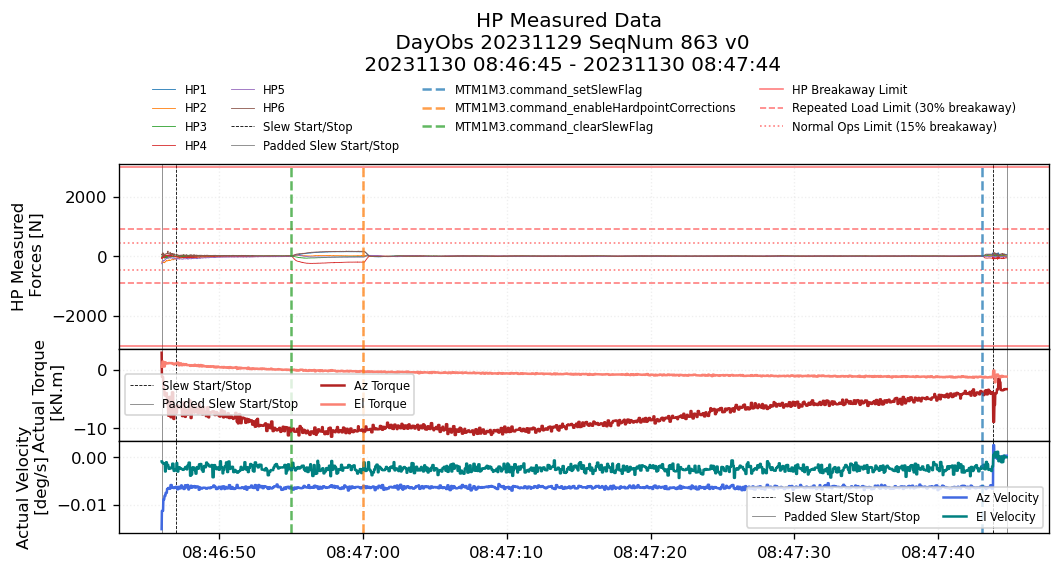

In [37]:
%matplotlib inline
data = analyze_m1m3_ics_slew_event(
    slew_data["20231129_ics_True_100"]["begin"],
    slew_data["20231129_ics_True_100"]["end"],
    tma_event_maker,
    plot_path,
)

print(data.stats)